In [1]:
datasetName = 'brain_hippocampus_Zhong2020'
#datasetName value: organ_tissue_authorYear without space
dataFormat = '10X'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/brain_hippocampus_Zhong2020")

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- data.table::fread(paste0(datasetName,"_expression.tsv.gz"), h = T, data.table = F)
} else{
   # system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
# data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)


In [3]:
dim(data.matrix)

[1] 32738 33128

In [4]:
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
# data.annotation[1:5,]

5 x 5 sparse Matrix of class "dgCMatrix"
             AAACCTGAGGAGTTGC-1 AAACCTGAGGGTCGAT-1 AAACCTGAGTATCGAA-1
MIR1302-10                    .                  .                  .
FAM138A                       .                  .                  .
OR4F5                         .                  .                  .
RP11-34P13.7                  .                  .                  .
RP11-34P13.8                  .                  .                  .
             AAACCTGAGTTAAGTG-1 AAACCTGCAATGCCAT-1
MIR1302-10                    .                  .
FAM138A                       .                  .
OR4F5                         .                  .
RP11-34P13.7                  .                  .
RP11-34P13.8                  .                  .

,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<fct>,<fct>,<lgl>,<fct>,<lgl>,<lgl>,<lgl>
AAACCTGAGGAGTTGC-1,brain,hippocampus,NA,normal,NA,NA,NA
AAACCTGAGGGTCGAT-1,brain,hippocampus,NA,normal,NA,NA,NA
AAACCTGAGTATCGAA-1,brain,hippocampus,NA,normal,NA,NA,NA
AAACCTGAGTTAAGTG-1,brain,hippocampus,NA,normal,NA,NA,NA
AAACCTGCAATGCCAT-1,brain,hippocampus,NA,normal,NA,NA,NA


In [4]:
# ?
# Cells that expressed haemoglobin genes (HBM, HBA1, HBA2, HBB, HBD, HBE1, HBG1, HBG2, HBQ1 and HBZ) were also excluded
# c('HBM', "HBA1", "HBA2", "HBB", "HBD", "HBE1", "HBG1", "HBG2", "HBQ1", "HBZ")
data.matrix2 <- data.matrix[, data.matrix['HBM',]==0]
data.matrix2 <- data.matrix2[, data.matrix2['HBA1',]==0]
data.matrix2 <- data.matrix2[, data.matrix2['HBA2',]==0]
data.matrix2 <- data.matrix2[, data.matrix2['HBB',]==0]
data.matrix2 <- data.matrix2[, data.matrix2['HBD',]==0]
data.matrix2 <- data.matrix2[, data.matrix2['HBE1',]==0]
data.matrix2 <- data.matrix2[, data.matrix2['HBG1',]==0]
data.matrix2 <- data.matrix2[, data.matrix2['HBG2',]==0]
data.matrix2 <- data.matrix2[, data.matrix2['HBQ1',]==0]
data.matrix2 <- data.matrix2[, data.matrix2['HBZ',]==0]
dim(data.matrix2)


[1] 32738  2635

In [5]:
# Pre-processing
min.cells = 30
min.features = 800
nFeature_RNA_range = c(min.features, 7000)
percent.mt.thre = 15
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, min.features = min.features, meta.data = data.metadata)
# dataobj <- AddMetaData(dataobj, metadata = data.annotation)
# QC
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)
dataobj@assays

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


$RNA
Assay data with 17747 features for 30933 cells
First 10 features:
 RP11-34P13.7, AL627309.1, AP006222.2, RP4-669L17.10, RP11-206L10.3,
RP11-206L10.2, RP11-206L10.9, LINC00115, FAM41C, RP11-54O7.1 


In [6]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'mvp', nfeatures = 982, mean.cutoff = c(0.0125, 8)
                                , dispersion.cutoff = c(2, Inf)) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj)
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [7]:
length(VariableFeatures(dataobj))

[1] 540

In [8]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  C1QC, C1QB, TYROBP, CSF1R, C1QA, LAPTM5, FCGR1A, VSIG4, AIF1, FOLR2 
	   TREM2, RGS10, PLD4, CD68, CX3CR1, GPR34, FCGRT, SPP1, ITGB2, SRGN 
	   A2M, CD53, SAMSN1, C10orf54, ADORA3, FCGR3A, RGS1, CSF2RA, RNASET2, LY86 
Negative:  MEIS2, PTPRZ1, SCGN, CALB2, CRYAB, PDZRN4, CALD1, CADM2, SERPINE2, PTN 
	   DLL3, AK1, TTYH1, SST, SCRG1, PLP1, EOMES, ID4, CLU, LUZP2 
	   NKAIN4, PMP2, BCAN, TMEM158, LRRC4C, LHFPL3, TNR, SYNPR, OLIG1, LRRIQ1 
PC_ 2 
Positive:  FTL, SPP1, C1QC, FCGR1A, C1QB, GPR34, C1QA, CSF1R, VSIG4, FOLR2 
	   CX3CR1, TREM2, PLD4, ADORA3, P2RY13, SAMSN1, CSF2RA, CD68, RGS10, FCGR3A 
	   AIF1, P2RY12, C3, LAPTM5, TYROBP, FCGR1B, LY86, CD53, IGSF6, OLR1 
Negative:  BGN, COL4A1, ITIH5, IGFBP7, ARHGAP29, FN1, HIGD1B, COL1A2, PLAC9, PDGFRB 
	   COL4A2, RGS5, PLXDC1, SPARC, GNG11, ATP1A2, TFPI, IFITM3, PRELP, KCNJ8 
	   FRZB, EDNRA, COLEC12, SLC6A12, NDUFA4L2, NOTCH3, GGT5, GPER1, FOXS1, DLC1 
PC_ 3 
Positive:  BCAN, S100B, SCRG1, OLIG1, MT3, PMP2, TTYH1, PDGFRA

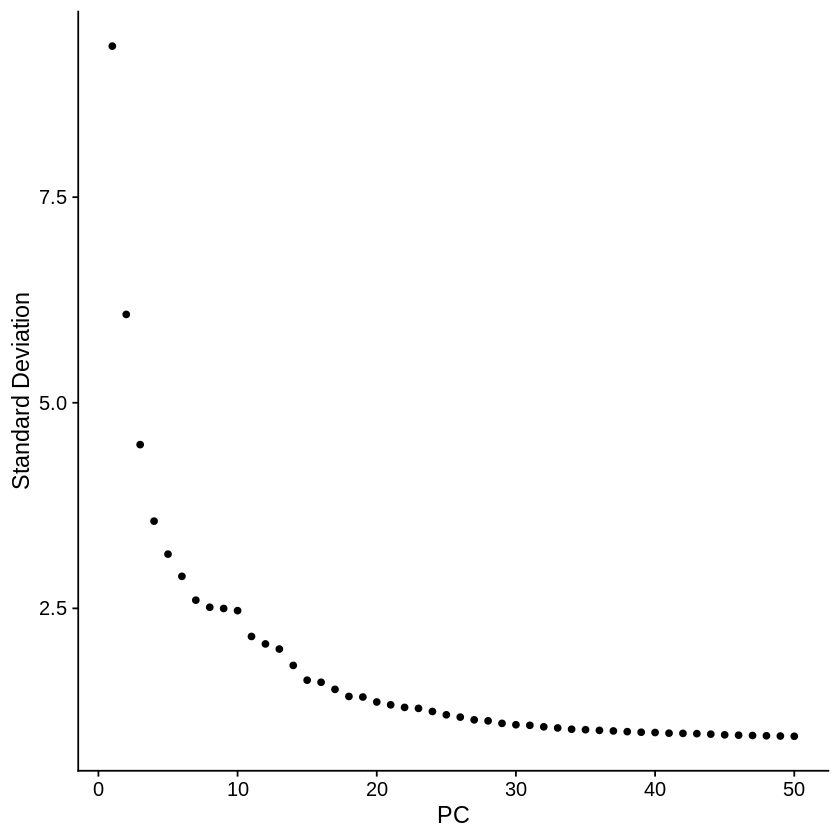

In [9]:
# dataobj <- JackStraw(dataobj, num.replicate = 100)
# dataobj <- ScoreJackStraw(dataobj, dims = 1:20)
# JackStrawPlot(dataobj, dims = 1:15)
ElbowPlot(dataobj, ndims = 50) 

In [10]:
# Cluster the cells
pcDim = 10
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim)
dataobj <- FindClusters(dataobj, resolution = 1.2)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 30933
Number of edges: 860775

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8264
Number of communities: 28
Elapsed time: 7 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
22:38:23 UMAP embedding parameters a = 0.9922 b = 1.112

22:38:23 Read 30933 rows and found 10 numeric columns

22:38:23 Using Annoy for neighbor search, n_neighbors = 30

22:38:23 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

22:38:28 Writing NN index file to temp file /tmp/RtmpuQ1Es4/file693d59b04330

22:38:28 Searching Annoy index using 1 thread, search_k = 3000

22:38:44 Annoy recall = 100%

22:38:45 Commencing smooth kNN distance calibration using 1 thread

22:38:46 Initializing f

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


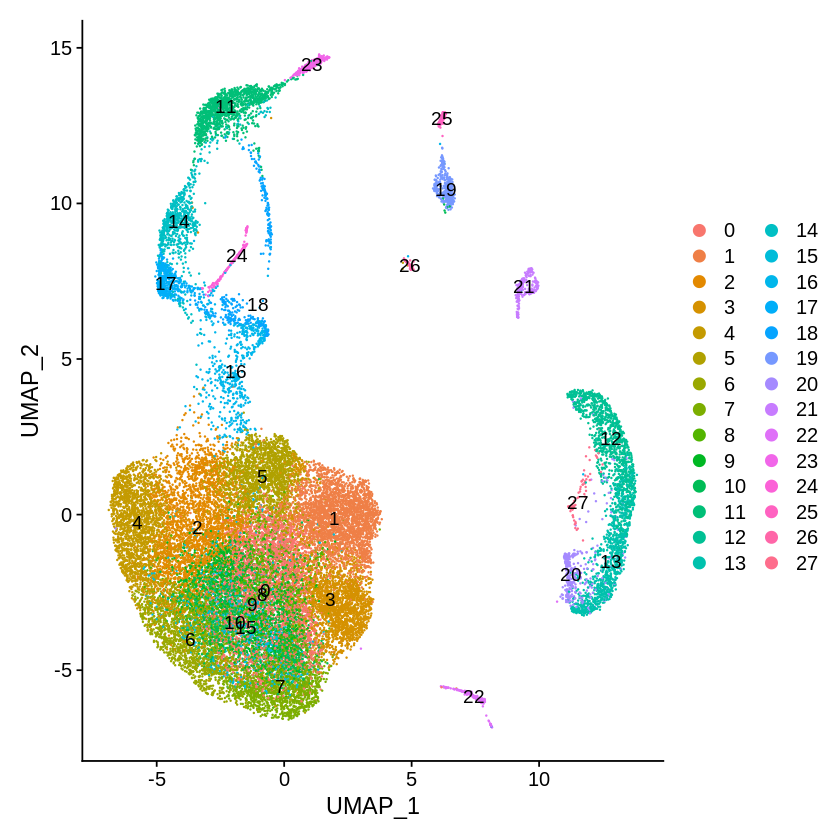

In [11]:
# Clusters marked by Seurat clustering results
# 用singleR看一下
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [15]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

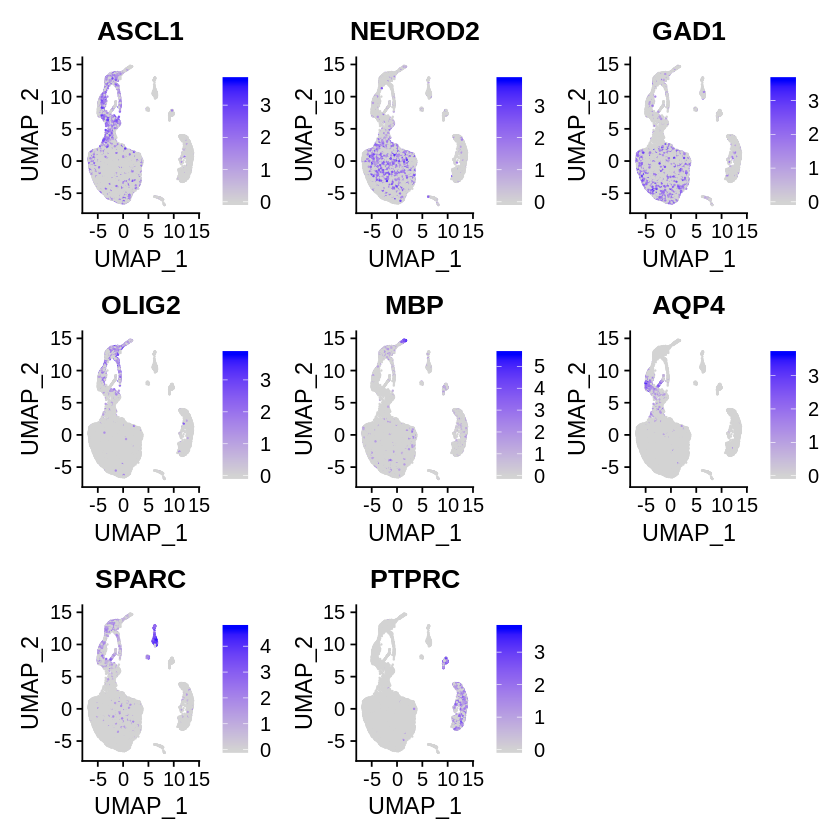

In [13]:
# The markers ASCL1, NEUROD2, GAD1, OLIG2, MBP, AQP4, SPARC and PTPRC were used to hippocampal cells as 
# progenitor cells, excitatory neurons, inhibitory neurons, OPCs, oligodendrocytes, astrocytes, endothelial cells and microglia.
p <- FeaturePlot(dataobj, features = c("ASCL1", "NEUROD2", "GAD1", "OLIG2", "MBP", "AQP4", "SPARC", "PTPRC"))
p

In [28]:
ggsave(paste0(datasetName,".featuremap.tiff"), plot = p, width = 10, height = 10)

In [14]:
# Finding cluster markers 
library(dplyr)
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
dataobj.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24

Calculating cluster 25

Calculating cluster 26

Calculating cluster 27



p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
6.998637e-221,0.5139977,0.642,0.372,1.242048e-216,0,NEUROD2
4.569617e-217,0.5125769,0.627,0.355,8.109700e-213,0,BHLHE22
6.787727e-195,0.5554043,0.525,0.284,1.204618e-190,0,NEUROD6
6.871809e-177,0.4690022,0.728,0.520,1.219540e-172,0,GAP43
4.978616e-162,0.4505083,0.630,0.412,8.835549e-158,0,PPP2R2B
4.495114e-145,0.4065134,0.773,0.614,7.977479e-141,0,APP
1.712794e-135,0.4431479,0.429,0.238,3.039696e-131,0,NRP1
3.327261e-130,0.4023447,0.739,0.593,5.904889e-126,0,ZBTB20
1.763145e-124,0.3957230,0.641,0.436,3.129053e-120,0,GRIA2


In [12]:
new.cluster.ids <- c('Brain-Nerve tissue-Excitatory neuron-NEUROD2', 'Brain-Nerve tissue-Excitatory neuron-NEUROD2',
                     'Brain-Nerve tissue-Excitatory neuron-NEUROD2','Brain-Nerve tissue-Excitatory neuron-NEUROD2',
                     'Brain-Nerve tissue-Inhibitory neuron-GAD1', 'Brain-Nerve tissue-Excitatory neuron-NEUROD2',
                     'Brain-Nerve tissue-Inhibitory neuron-GAD1','Brain-Nerve tissue-Inhibitory neuron-GAD1',
                     'Brain-Nerve tissue-Inhibitory neuron-GAD1',
                     'Brain-Nerve tissue-Excitatory neuron-NEUROD2', 'Brain-Nerve tissue-Inhibitory neuron-GAD1',
                     'Brain-Nerve tissue-OPC-OLIG2', 'Brain-Nerve tissue-Microglia-PTPRC', 'Brain-Nerve tissue-Microglia-PTPRC', 
                     'Brain-Nerve tissue-Progenitor-ASCL1', 'Brain-Nerve tissue-Inhibitory neuron-GAD1', 
                     'Brain-Nerve tissue-Progenitor-ASCL1',
                     'Brain-Nerve tissue-Astrocyte-AQP4','Brain-Nerve tissue-Progenitor-ASCL1','Brain-Epithelial tissue-Endothelial cell-SPARC',
                    'Brain-Nerve tissue-Microglia-PTPRC','Brain-Nerve tissue-Microglia-PTPRC','?','Brain-Nerve tissue-Oligodendrocyte-MBP', 
                     'Brain-Nerve tissue-Astrocyte-AQP4',
                    'Brain-Epithelial tissue-Endothelial cell-SPARC','Brain-Epithelial tissue-Endothelial cell-SPARC',
                     'Brain-Nerve tissue-Microglia-PTPRC')
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

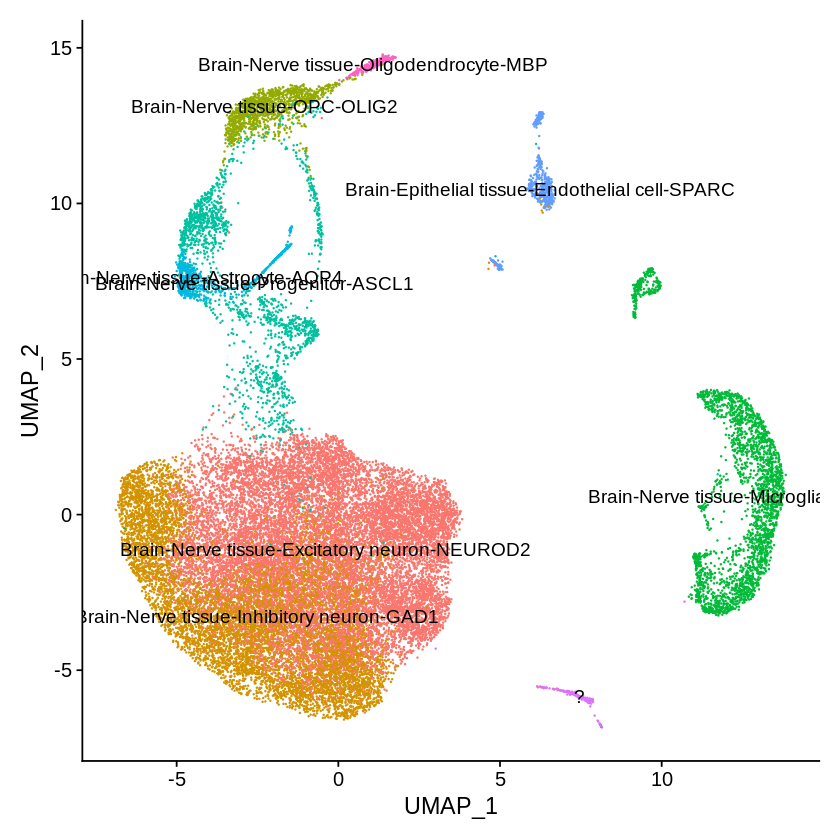

In [13]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE) + NoLegend()
p_umap2

In [18]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [22]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)


Calculating cluster Oligodendrocyte

Calculating cluster Astrocyte

Calculating cluster Glutamatergic neuron

Calculating cluster GABAergic neuron

Calculating cluster Microglia

Calculating cluster OPC

Calculating cluster Endothelial cell



In [15]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))